### Strength of schedule estimation usage of `turf`

---

This notebook demonstrates how to estimate a team's strength of schedule for the games a team has `played`, for the remaining `unplayed` games, and for the `full` season. Here, we estimate the strength of schedule for the given games as the winning percentage of the median team if it were to play the given team's schedule.

David Fleming, 2023

In [1]:
import numpy as np
import pymc as pm
import arviz as az
from turf import scrape, utils, inference

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

**Initiate and fit model**

---


In [2]:
# Pull season results to-date
season = scrape.Season(year=2023, week=None)

/Users/davidfleming/turf/turf/scrape.py:133: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_html(url, parse_dates=True, attrs={'id': 'games'},


In [3]:
# Initialize model
model = inference.CorrelatedPoisson(season)

In [4]:
# Run inference on 4 cores (1 chain per core)
model.run_inference(tune=1000, draws=2500, target_accept=0.9, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, intercept, chol_cov, atts_defs_star]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 25 seconds.


In [5]:
# Examine MCMC statistics to check convergence
az.summary(model.trace_, group='posterior', var_names=['att'], filter_vars='like')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"atts_defs_star[ARZ, att]",-0.154,0.083,-0.312,-0.001,0.001,0.001,7167.0,7177.0,1.0
"atts_defs_star[ARZ, def]",0.138,0.066,0.017,0.265,0.001,0.000,10652.0,7026.0,1.0
"atts_defs_star[ATL, att]",-0.134,0.082,-0.287,0.022,0.001,0.001,8686.0,7252.0,1.0
"atts_defs_star[ATL, def]",0.027,0.068,-0.104,0.153,0.001,0.001,12953.0,7854.0,1.0
"atts_defs_star[BLT, att]",0.254,0.073,0.117,0.389,0.001,0.001,5937.0,7275.0,1.0
...,...,...,...,...,...,...,...,...,...
atts[SEA],0.002,0.068,-0.127,0.126,0.000,0.001,21585.0,7703.0,1.0
atts[SF],0.276,0.065,0.160,0.404,0.000,0.000,18799.0,7841.0,1.0
atts[TB],-0.077,0.071,-0.204,0.061,0.000,0.000,20079.0,8153.0,1.0
atts[TEN],-0.145,0.076,-0.282,0.003,0.001,0.000,22457.0,8123.0,1.0


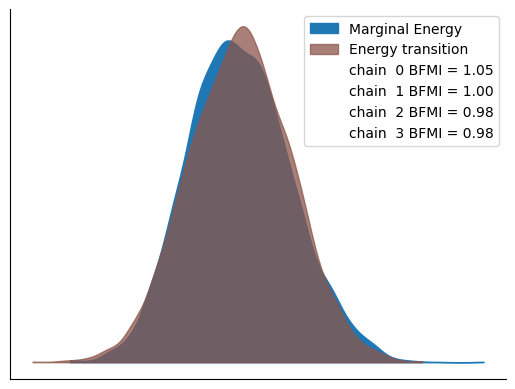

In [6]:
# Same as above, but visualizing energy of chain transition
# Should be ~1 for good convergence
ax = az.plot_energy(model.trace_)
sns.despine(ax=ax)

**Estimate strength of schedule**

---

Simulate NFL results to estimate a team's strength of schedule as the win percentage of the median team playing the same schedule.
This function returns the strength of schedule estimate for the `full` season, `played` games, and the remaining `unplayed` games.

**Strength of schedule for games already played**

---

Which teams have played the most difficult schedule so far?

In [7]:
# Estimate strength of schedule for games already played
sos_played, team_names = model.sos(n=250, mode='played')

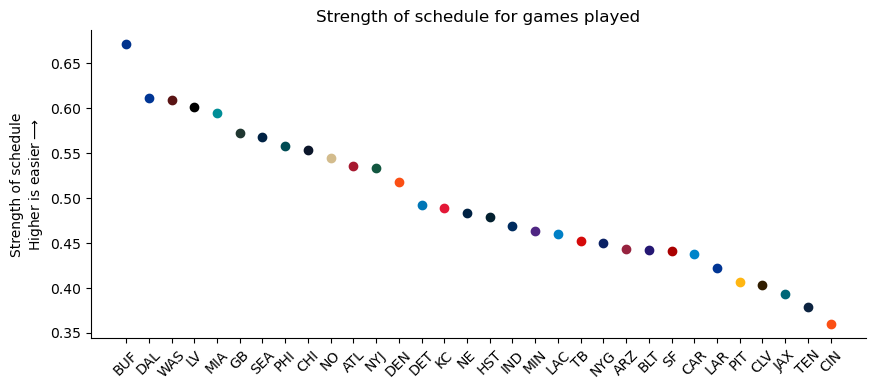

In [8]:
# Plot ordered strength of schedule
fig, ax = plt.subplots(figsize=(10,4))

# Order values by easiest to most difficult schedule
inds = np.argsort(sos_played)[::-1]
pri_colors = list(map(lambda x : utils._hex_color[f"{x}_0"], team_names))

x = np.arange(len(team_names))
for ii in range(len(x)):
    ax.scatter(x[ii], sos_played[inds[ii]], color=pri_colors[inds[ii]])

ax.set_xlabel('')
ax.set_ylabel('Strength of schedule\nHigher is easier$\longrightarrow$')
ax.set_title('Strength of schedule for games played')
_ = ax.set_xticks(x)
_ = ax.set_xticklabels(model._coords["teams"][inds], rotation=45)
sns.despine(ax=ax)

**Strength of schedule for the rest of the season**

---

Which teams have the most difficult schedule remaining?

In [9]:
# Estimate strength of schedule for remaining games
sos_unplayed, team_names = model.sos(n=250, mode='unplayed')

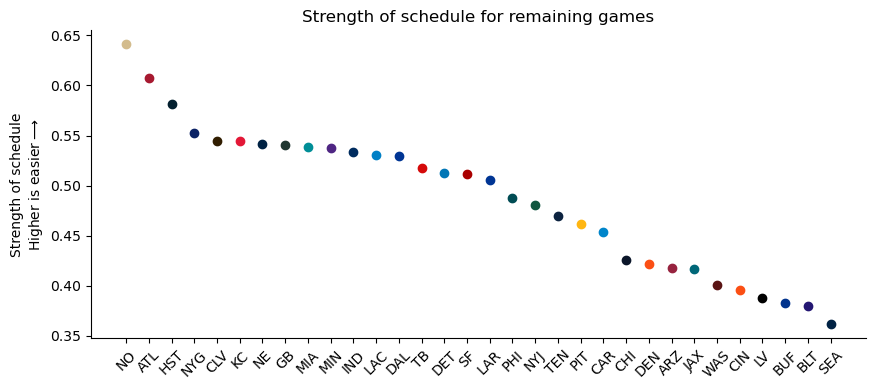

In [10]:
# Plot ordered strength of schedule
fig, ax = plt.subplots(figsize=(10,4))

# Order values by easiest to most difficult schedule
inds = np.argsort(sos_unplayed)[::-1]
pri_colors = list(map(lambda x : utils._hex_color[f"{x}_0"], team_names))

x = np.arange(len(team_names))
for ii in range(len(x)):
    ax.scatter(x[ii], sos_unplayed[inds[ii]], color=pri_colors[inds[ii]])

ax.set_xlabel('')
ax.set_ylabel('Strength of schedule\nHigher is easier$\longrightarrow$')
ax.set_title('Strength of schedule for remaining games')
_ = ax.set_xticks(x)
_ = ax.set_xticklabels(model._coords["teams"][inds], rotation=45)
sns.despine(ax=ax)

Now let's look at which teams have the biggest jump in strength of schedule, that is, which teams have the toughest remaining schedule relative to what they have already played.

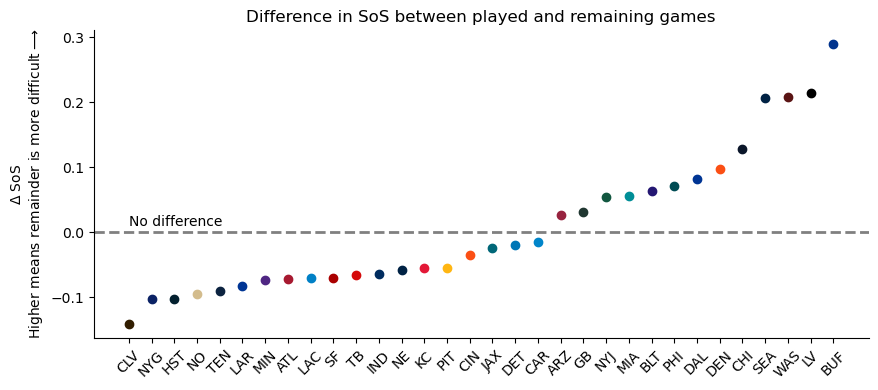

In [11]:
# Difference between played and unplayed sos
sos_delta = sos_played - sos_unplayed

# Plot ordered strength of schedule
fig, ax = plt.subplots(figsize=(10,4))

# Order values by easiest to most difficult schedule
inds = np.argsort(sos_delta)
pri_colors = list(map(lambda x : utils._hex_color[f"{x}_0"], team_names))

x = np.arange(len(team_names))
for ii in range(len(x)):
    ax.scatter(x[ii], sos_delta[inds[ii]], color=pri_colors[inds[ii]], zorder=1)

ax.axhline(0, lw=2, ls='--', color='grey', zorder=0)
ax.text(0, 0.01, 'No difference')
ax.set_xlabel('')
ax.set_ylabel('$\Delta$ SoS\nHigher means remainder is more difficult$\longrightarrow$')
ax.set_title('Difference in SoS between played and remaining games')
_ = ax.set_xticks(x)
_ = ax.set_xticklabels(model._coords["teams"][inds], rotation=45)
sns.despine(ax=ax)

**Full season strength of schedule**

---

Which teams have the most difficult schedule?

In [12]:
# Estimate strength of schedule for remaining games
sos_full, team_names = model.sos(n=250, mode='full')

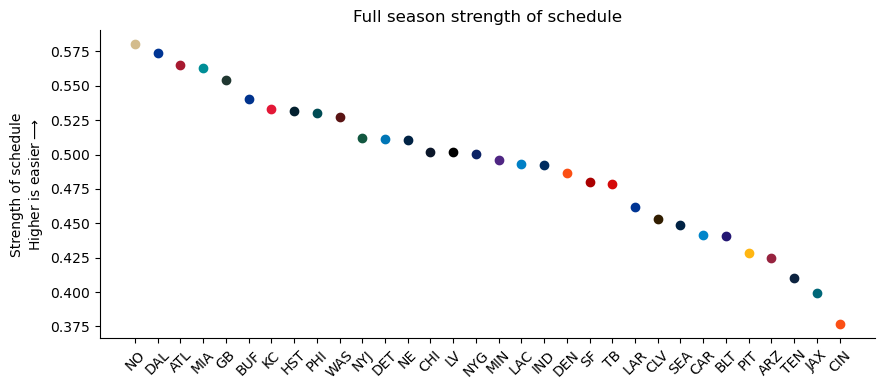

In [13]:
# Plot ordered strength of schedule
fig, ax = plt.subplots(figsize=(10,4))

# Order values by easiest to most difficult schedule
inds = np.argsort(sos_full)[::-1]
pri_colors = list(map(lambda x : utils._hex_color[f"{x}_0"], team_names))

x = np.arange(len(team_names))
for ii in range(len(x)):
    ax.scatter(x[ii], sos_full[inds[ii]], color=pri_colors[inds[ii]])

ax.set_xlabel('')
ax.set_ylabel('Strength of schedule\nHigher is easier$\longrightarrow$')
ax.set_title('Full season strength of schedule')
_ = ax.set_xticks(x)
_ = ax.set_xticklabels(model._coords["teams"][inds], rotation=45)
sns.despine(ax=ax)

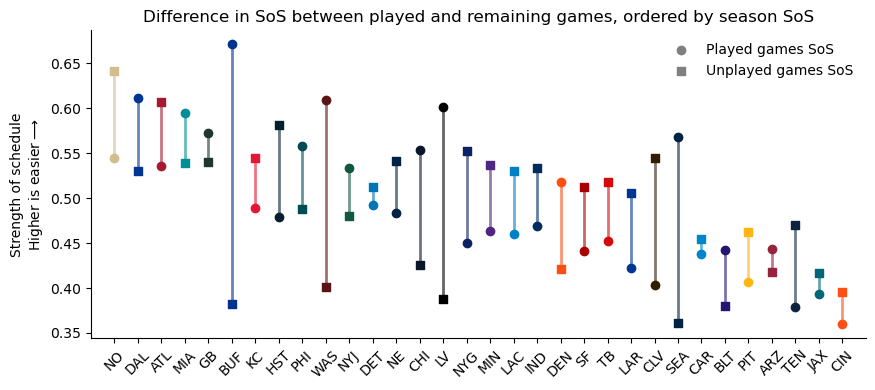

In [14]:
# Plot ordered strength of schedule
fig, ax = plt.subplots(figsize=(10,4))

# Order values by easiest to most difficult schedule
inds = np.argsort(sos_full)[::-1]
pri_colors = list(map(lambda x : utils._hex_color[f"{x}_0"], team_names))

x = np.arange(len(team_names))
for ii in range(len(x)):
    # Plot difference between played and unplayed SoS
    ax.plot([x[ii], x[ii]],
            [sos_unplayed[inds[ii]], sos_played[inds[ii]]], 
            color=pri_colors[inds[ii]], zorder=1, lw=2, alpha=0.6)

    # Plot individual points
    ax.scatter(x[ii], sos_unplayed[inds[ii]], color=pri_colors[inds[ii]], marker='s')
    ax.scatter(x[ii], sos_played[inds[ii]], color=pri_colors[inds[ii]])

# Dummy points for legend
ax.scatter(100, 0.5, color='grey', marker='o', label='Played games SoS')
ax.scatter(100, 0.5, color='grey', marker='s', label='Unplayed games SoS')

# Format
ax.legend(loc='upper right', framealpha=0)
ax.set_xlim(np.min(x)-1, np.max(x)+1)
ax.set_xlabel('')
ax.set_ylabel('Strength of schedule\nHigher is easier$\longrightarrow$')
ax.set_title('Difference in SoS between played and remaining games, ordered by season SoS')
_ = ax.set_xticks(x)
_ = ax.set_xticklabels(model._coords["teams"][inds], rotation=45)
sns.despine(ax=ax)

**Documentation**

---

Check out the function and its docstring for more information on how it works and how to use it.

In [15]:
# Check out the function for estimating the strength of schedule
model.sos??

Signature: model.sos(n: int = 100, mode='full') -> numpy.ndarray
Source:   
    def sos(self, n : int=100, mode='full') -> Union[np.ndarray, np.ndarray]:
        """
        Simulate NFL results to estimate a team's strength of schedule 
        as the win percentage of the median team playing the same schedule.

        Parameters
        ----------
        n : int (optional)
            Number of times to simulate each game. Defaults to 100.
        mode : str (optional)
            Estimate SoS for the 'full', 'played', or 'unplayed' games 
            of the season for each team

        Returns
        -------
        sos : np.ndarray
            Strength of schedule for teams in team_names
        team_names : np.ndarray
            Array of team names aligned with SOS
        """

        # Assert model is fit with new util fn
        assert ut.check_model_inference(self.model), "model must be ran via model.run_inference() prior to simulations"

        # Extract df of all games